# Basic examples

In this notebook we will show how to fit a model to data, in the **desilike** framework.
You need to have installed **desilike** with:
```
python -m pip install git+https://github.com/cosmodesi/desilike#egg=desilike
```
For the analytic solver:
```
python -m pip install jax[cpu]
```

## Model
Let us define a simple, affine model.

In [1]:
from desilike.base import BaseCalculator


class AffineModel(BaseCalculator):  # all calculators should inherit from BaseCalculator

    # Model parameters; those can also be declared in a yaml file
    _params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}},
               'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}
    
    def initialize(self, x=None):
        # Actual, non-trivial initialization must happen in initialize(); this is to be able to do AffineModel(x=...)
        # without doing any actual work
        self.x = x
    
    def calculate(self, a=0., b=0.):
        self.y = a * self.x + b  # simple, affine model
    
    # Not mandatory, this is to return something in particular after calculate (else this will just be the instance)
    def get(self):
        return self.y
    
    # This is only needed for emulation
    def __getstate__(self):
        return {'x': self.x, 'y': self.y}  # dictionary of Python base types and numpy arrays

## Likelihood

Let us define our Gaussian likelihood.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from desilike.likelihoods import BaseGaussianLikelihood


class Likelihood(BaseGaussianLikelihood):
    
    def initialize(self, theory=None):
        # Let us generate some fake data
        self.xdata = np.linspace(0., 1., 10)
        mean = np.zeros_like(self.xdata)
        self.covariance = np.eye(len(self.xdata))
        rng = np.random.RandomState(seed=42)
        y = rng.multivariate_normal(mean, self.covariance)
        super(Likelihood, self).initialize(y, covariance=self.covariance)
        # Requirements
        # AffineModel will be instantied with AffineModel(x=self.xdata)
        if theory is None:
            theory = AffineModel()
        self.theory = theory
        self.theory.init.update(x=self.xdata)  # we set x-coordinates, they will be passed to AffineModel's initialize
    
    @property
    def flattheory(self):
        # Requirements (theory, requested in __init__) are accessed through .name
        # The pipeline will make sure theory.run(a=..., b=...) has been called
        return self.theory.y  # data - model

    def plot(self):
        ax = plt.gca()
        ax.errorbar(self.xdata, self.flatdata, yerr=np.diag(self.covariance)**0.5, color='k', linestyle='none', marker='o', label='data')
        ax.plot(self.xdata, self.flattheory, color='r', label='theory')
        ax.grid()
        ax.legend()
        return ax

## Pipeline
Let us initialize our likelihood pipeline, that connects the theory and the likelihood.

In [3]:
from desilike import setup_logging

setup_logging()  # set up logging

likelihood = Likelihood()
likelihood.runtime_info.pipeline.calculators

In [4]:
# One can evaluate the theory directly with:
theory = likelihood.theory
y = theory(a=1., b=2.)

# One can also evaluate the likelihood directly
loglikelihood = likelihood(a=1., b=2.)
print('Loglikelihood is {:.3f}'.format(loglikelihood))

y = likelihood.theory.y
loglikelihood = likelihood(a=1., b=1.)
# The model has been run for this new set of parameters
assert id(likelihood.theory.y) != id(y)

y = likelihood.theory.y
loglikelihood = likelihood(a=1., b=1.)
# The model hasn't be rerun because it has just been run with these parameters
assert id(likelihood.theory.y) == id(y)

# Parameters of a given calculator, can be updated through
theory.init.params = {'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 2.}},
                      'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 2.}}}
fn = '_tests/params.yaml'
# Writing file with parameters fn
from desilike.io import BaseConfig
BaseConfig({'a': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 1.}},
            'b': {'value': 0., 'prior': {'dist': 'norm', 'loc': 0., 'scale': 1.}}}).write(fn)
with open(fn, 'r') as file: print(file.read())
theory.init.params = fn
print(theory.init.params)

# One can update all the likelihood parameters as
likelihood.all_params['b'].update(prior={'dist': 'norm', 'loc': 0., 'scale': 100.})
assert likelihood.varied_params['b'].prior.scale == 100.
# Or update e.g. the prior of parameters that start with 'a'
likelihood.all_params = {'a*': {'prior': {'dist': 'norm', 'loc': 0., 'scale': 2.}}}
assert all(param.prior.scale == 2. for param in likelihood.varied_params.select(name='a*'))
# Or set params from file
# Just writing file with parameters fn
from desilike.io import BaseConfig
BaseConfig({'*': {'prior': {'dist': 'norm', 'loc': 0., 'scale': 10.}}}).write(fn)
with open(fn, 'r') as file: print(file.read())
likelihood.all_params = fn
assert all(param.prior.scale == 10. for param in likelihood.varied_params.select(name='a*'))

Loglikelihood is -24.002
[000000.42] [0/1] 02-05 12:04  BaseConfig                INFO     Saving _tests/params.yaml.
a:
  value: 0.0
  prior:
    dist: norm
    loc: 0.0
    scale: 1.0
b:
  value: 0.0
  prior:
    dist: norm
    loc: 0.0
    scale: 1.0

ParameterCollection(['a', 'b'])
[000000.42] [0/1] 02-05 12:04  BaseConfig                INFO     Saving _tests/params.yaml.
'*':
  prior:
    dist: norm
    loc: 0.0
    scale: 10.0



In [5]:
# If you wish to use your own profiler / sampler, that hasn't be wrapped into desilike (yet)
# just use the likelihood above as a function, and parameters to be varied are:
print('Parameters to be varied are {}.'.format(likelihood.varied_params.names()))
# Some initial values can be obtained through [param.ref.sample() for param in likelihood.varied_params]
# Prior for a given parameter is param.prior(x)

# If you wish to take advantage of the least-square nature of the problem, e.g. with scipy.optimize.curve_fit
from scipy import optimize
names = likelihood.varied_params.names()

def f(x, *params):
    return theory(dict(zip(names, params)))

xdata = np.ones_like(likelihood.flatdata)
ydata = likelihood.flatdata
p0 = [param.value for param in likelihood.varied_params]
sigma = likelihood.covariance
popt, pcov = optimize.curve_fit(f, xdata, ydata, p0=p0, sigma=sigma)[:2]
print('Best-fit parameters are: {}.'.format(popt))

Parameters to be varied are ['a', 'b'].
Best-fit parameters are: [-0.06210334  0.47911278].


## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [6]:
from desilike.profilers import MinuitProfiler
# If iminuit is not installed, you can do:
# from desilike import Installer
# installer = Installer(user=True)  # to install in you user's directory
# installer(MinuitProfiler)
# Reminder: if you want explanation on how to use MinuitProfiler:
help(MinuitProfiler)

Help on class MinuitProfiler in module desilike.profilers.minuit:

class MinuitProfiler(desilike.profilers.base.BaseProfiler)
 |  MinuitProfiler(*args, gradient=False, **kwargs)
 |  
 |  Wrapper for minuit profiler, used by the high-energy physics community for likelihood profiling.
 |  
 |  Reference
 |  ---------
 |  - https://github.com/scikit-hep/iminuit
 |  - https://ui.adsabs.harvard.edu/abs/1975CoPhC..10..343J/abstract
 |  
 |  Method resolution order:
 |      MinuitProfiler
 |      desilike.profilers.base.BaseProfiler
 |      desilike.utils.BaseClass
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, gradient=False, **kwargs)
 |      Initialize profiler.
 |      
 |      Parameters
 |      ----------
 |      likelihood : BaseLikelihood
 |          Input likelihood.
 |      
 |      rng : np.random.RandomState, default=None
 |          Random state. If ``None``, ``seed`` is used to set random state.
 |      
 |      seed : int, default=None
 | 

In [7]:
# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=5)

[000000.50] [0/1] 02-05 12:04  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].
[000000.59] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.


In [8]:
# Quantities can be accessed through:
print(profiles.bestfit['a'])

# Save/load example
import os
import tempfile
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    profiles.save(fn)
    from desilike.samples import Profiles
    profiles = Profiles.load(fn)

print(profiles.to_stats(tablefmt='pretty'))

ParameterArray(a, None, [-0.05917982 -0.05917982 -0.05917982 -0.05917982 -0.05917982])
[000000.87] [0/1] 02-05 12:04  Profiles                  INFO     Saving /tmp/tmproi2wc2t/tmp.npy.
[000000.88] [0/1] 02-05 12:04  Profiles                  INFO     Loading /tmp/tmproi2wc2t/tmp.npy.
+-----------------------------------+--------+---------+-------+
| chi2 / (10 - 2) = 4.70 / 8 = 0.59 | varied | bestfit | error |
+-----------------------------------+--------+---------+-------+
|                 a                 |  True  |  -0.06  | 0.98  |
|                 b                 |  True  |  0.48   | 0.58  |
+-----------------------------------+--------+---------+-------+


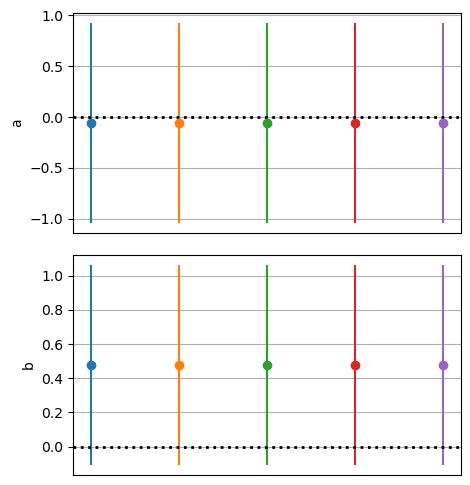

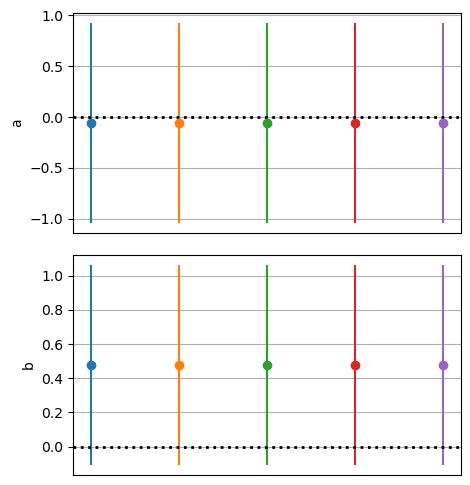

In [9]:
from desilike.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiles, truths=[0., 0.])

In [10]:
# Compute \Delta \chi^{2} = cl^2 = 1 interval for the best best of above best fits
profiles = profiler.interval(cl=1)
# Interval can be accessed through
profiles.interval['a']
print(profiles.to_stats(tablefmt='latex_raw'))

[000001.13] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
\begin{tabular}{lllll}
\hline
 $\chi^{2} / (10 - 2) = 4.70 / 8 = 0.59$   & varied   & bestfit   & error   & interval             \\
\hline
 a                                         & True     & $-0.06$   & $0.98$  & ${}_{-0.98}^{+0.98}$ \\
 b                                         & True     & $0.48$    & $0.58$  & ${}_{-0.58}^{+0.58}$ \\
\hline
\end{tabular}


[000001.19] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000001.30] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000001.73] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.


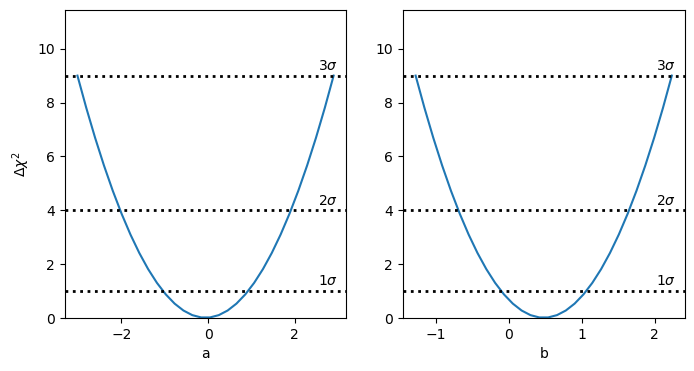

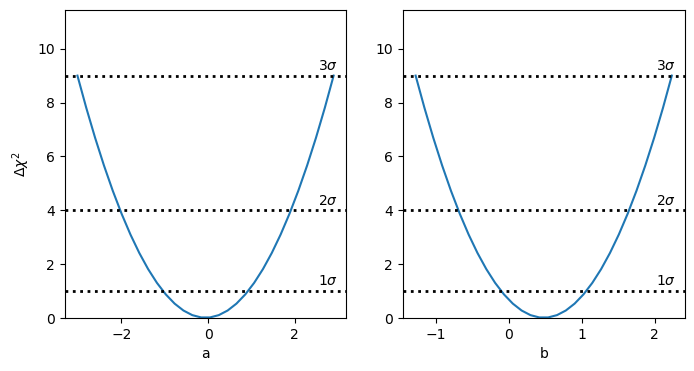

In [11]:
# Profile posterior up to cl = 3 sigmas
profiles = profiler.profile(cl=3)
# And plot, subtracting \chi^{2} at best fit
plotting.plot_profile(profiles, offsets=profiles.bestfit.logposterior.max())

## Analytic solver
If jax is installed (maybe we will provide an alterative relying on numpy only?), one can perform analytic marginalization over the parameters for which the model is linear.

In [12]:
# Specify we want to analytical solve for parameter 'b'
# 'derived' can be '.best' (fixed to best fit), '.marg' (analytic marginalization)
# or '.auto', which will be '.best' in case of likelihood profiling, '.marg' in case of sampling
likelihood.all_params['b'].update(derived='.auto')

profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=5)

[000002.37] [0/1] 02-05 12:04  MinuitProfiler            INFO     Varied parameters: ['a'].
[000003.45] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.


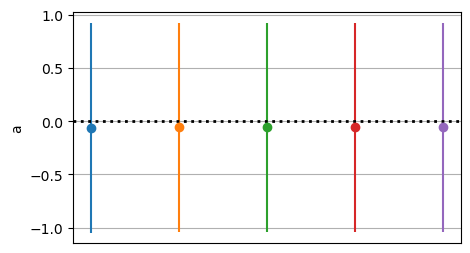

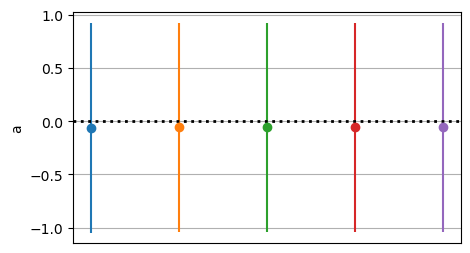

In [13]:
from desilike.samples import plotting
# Compare different best fits: all good, no convergence issues!
plotting.plot_aligned_stacked(profiles, truths=[0., 0.])

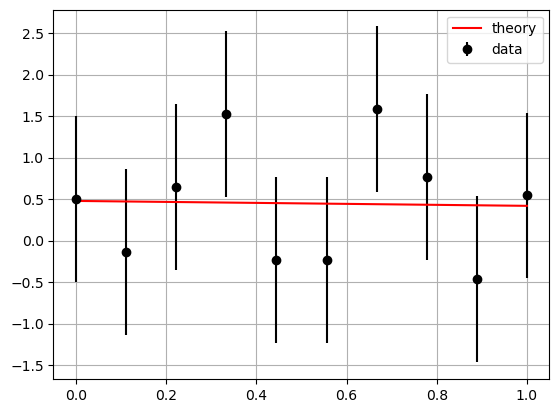

In [14]:
likelihood(**profiler.profiles.bestfit.choice(varied=True))
likelihood.plot()
plt.show()

## Sample
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [15]:
from desilike.samplers import ZeusSampler

# If zeus-mcm is not installed, you can do:
# from desilike import Installer
# installer = Installer(user=True)  # to install in you user's directory
# installer(ZeusSampler)

likelihood.all_params['b'].update(derived=False)
# By default are running 1 chain
# We can as for me, e.g. chains=2
# MPI processes will be evenly split across all the chains
sampler = ZeusSampler(likelihood, seed=42, nwalkers=10)
# We run samples until convergence, considered reached when Gelman-Rubin (computed over 4 chain subsamples) stabilizes < 0.03; 
sampler.run(check={'max_eigen_gr': 0.03})

[000004.41] [0/1] 02-05 12:04  ZeusSampler               INFO     Varied parameters: ['a', 'b'].
[000004.54] [0/1] 02-05 12:04  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
[000005.10] [0/1] 02-05 12:04  ZeusSampler               INFO     Successfully vmap input likelihood.
[000005.15] [0/1] 02-05 12:04  ZeusSampler               INFO     Successfully jit input likelihood.
[000005.23] [0/1] 02-05 12:04  root                      INFO     Initialising ensemble of 10 walkers...
[000013.80] [0/1] 02-05 12:04  ZeusSampler               INFO     Diagnostics:
[000013.81] [0/1] 02-05 12:04  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.00474; < 0.03.
[000013.81] [0/1] 02-05 12:04  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is 0.00214.
[000013.85] [0/1] 02-05 12:04  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.0904.
[000013.85] [0/1] 02-05 12:04  Diagnostics               INFO     - max Gewek

/local/home/adematti/software/desi/cosmodesiconda/20250205-1.0.0/conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


[000021.29] [0/1] 02-05 12:04  ZeusSampler               INFO     Diagnostics:
[000021.29] [0/1] 02-05 12:04  Diagnostics               INFO     - max eigen Gelman-Rubin - 1 is 0.00329; < 0.03.
[000021.30] [0/1] 02-05 12:04  Diagnostics               INFO     - max diag Gelman-Rubin - 1 is -0.000202.
[000021.34] [0/1] 02-05 12:04  Diagnostics               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.035.
[000021.35] [0/1] 02-05 12:04  Diagnostics               INFO     - max Geweke is 0.215.
[000021.35] [0/1] 02-05 12:04  Diagnostics               INFO     - Geweke p-value is 0.459.
[000021.35] [0/1] 02-05 12:04  Diagnostics               INFO     - effective sample size = (300 iterations / integrated autocorrelation time) (reliable) is 113.
[000021.35] [0/1] 02-05 12:04  Diagnostics               INFO     - max variation of integrated autocorrelation time is 0.249.


[Chain(shape=(600, 10), params=ParameterCollection(['a', 'b', 'logposterior', 'loglikelihood', 'logprior']))]

In [16]:
# If we want more samples, we can repeat run() calls, e.g.:
chains = sampler.run(max_iterations=200)

[000021.36] [0/1] 02-05 12:04  root                      INFO     Initialising ensemble of 10 walkers...


In [17]:
# Let's remove burnin and get basic stats
chain = chains[0].remove_burnin(0.5)

# Save/load example
import tempfile
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    chain.save(fn)
    from desilike.samples import Chain
    chain = Chain.load(fn)

print(chain.to_stats(tablefmt='pretty'))

[000026.45] [0/1] 02-05 12:04  Chain                     INFO     Saving /tmp/tmpr3f1wy2u/tmp.npy.
[000026.46] [0/1] 02-05 12:04  Chain                     INFO     Loading /tmp/tmpr3f1wy2u/tmp.npy.
+---+--------+-------+--------+------+-----------------+-----------------+
|   | argmax | mean  | median | std  | quantile:1sigma | interval:1sigma |
+---+--------+-------+--------+------+-----------------+-----------------+
| a | -0.07  | -0.06 | -0.06  | 0.97 |   -0.95/+0.96   |   -0.99/+0.90   |
| b |  0.49  | 0.47  |  0.47  | 0.59 |   -0.60/+0.58   |   -0.58/+0.59   |
+---+--------+-------+--------+------+-----------------+-----------------+


Removed no burn in


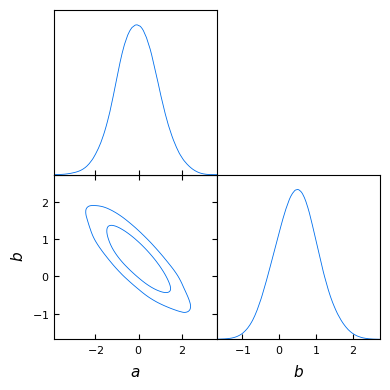

In [18]:
# This actually uses GetDist
# chain.to_getdist() will return a getdist.MCSamples object to play further
plotting.plot_triangle(chain)

In [19]:
# One can also perform likelihood profiling with minuit
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize()
profiler.profile(cl=3)
for cl in [1, 2]: profiler.contour(cl=cl)

[000026.89] [0/1] 02-05 12:04  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].
[000026.95] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000027.03] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000027.12] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000027.48] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000027.80] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000027.91] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000028.43] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.
[000028.52] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.


Removed no burn in


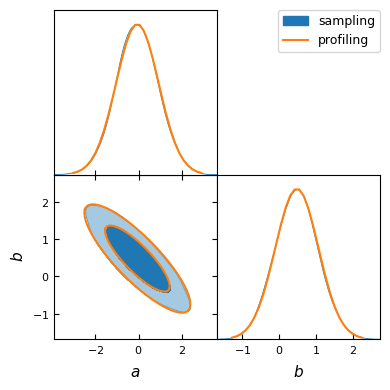

In [20]:
# Now compare to the sampling: same in the Gaussian case!
plotting.plot_triangle([chain, profiles], labels=['sampling', 'profiling'], filled=[True, False], contour_colors=['C0', 'C1'])

## Emulate
If our model took a lot of time to run, we would likely want to build an emulator for it. Let us try this on this simple model.

[000029.46] [0/1] 02-05 12:04  Emulator                  INFO     Varied parameters: ['a', 'b'].
[000029.46] [0/1] 02-05 12:04  Emulator                  INFO     Found varying ['y'] and fixed ['x'] outputs.
[000029.46] [0/1] 02-05 12:04  Differentiation           INFO     Varied parameters: ['a', 'b'].
[000029.54] [0/1] 02-05 12:04  Differentiation           INFO     Using auto-differentiation for parameter a.
[000029.55] [0/1] 02-05 12:04  Differentiation           INFO     Using auto-differentiation for parameter b.
[000029.55] [0/1] 02-05 12:04  Differentiation           INFO     Differentiation will evaluate 1 points.
[000029.70] [0/1] 02-05 12:04  Emulator                  INFO     Fitting y.
[000029.70] [0/1] 02-05 12:04  Emulator                  INFO     Diagnostics:
[000029.88] [0/1] 02-05 12:04  Emulator                  INFO     - mse of y is 0 (square root = 0).


[<Figure size 600x600 with 2 Axes>]

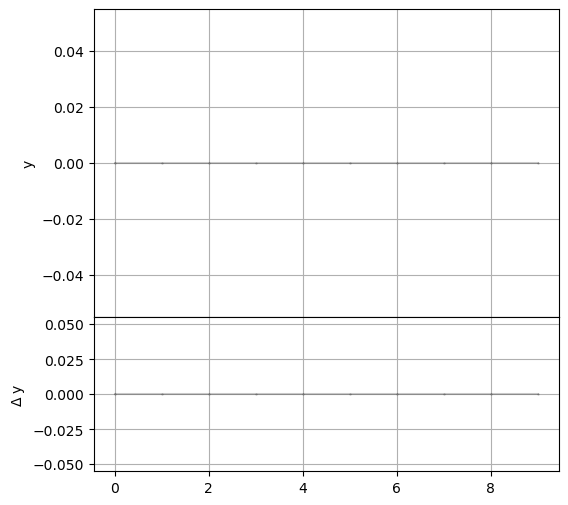

In [21]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

# Let's take the calculator we want to emulate, i.e. theory (AffineModel)
# Let us perform a Taylor expansion of order 1 for all attributes
# Attributes of AffineModel instance, obtained through theory.__getstate__()
# are automatically split between varied and fixed categories

emulator = Emulator(likelihood.theory, engine=TaylorEmulatorEngine(order=1))
emulator.set_samples()
emulator.fit()
emulator.check()  # since model is linear, non-zero mse is just due to numerical noise
emulator.plot()  # plot some theory.y samples, and the difference emulator - model at the bottom; all good!

In [22]:
# Now dump the emulator to disk
base_dir = '_tests'
fn = os.path.join(base_dir, 'emulator.npy')
emulator.save(fn)

[000030.01] [0/1] 02-05 12:04  Emulator                  INFO     Saving _tests/emulator.npy.
[000030.01] [0/1] 02-05 12:04  BaseConfig                INFO     Saving _tests/emulator.yaml.


In [23]:
# A yaml file is exported, which helps recollect the parameters of the emulator
# The parameters that have been varied should be specified when using this emulator,
# other parameters (fixed) can be removed if necessary
with open(fn.replace('.npy', '.yaml')) as file:
    print(file.read())

class: AffineModel
info: {}
params:
  a:
    value: 0.0
    fixed: false
    derived: false
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: null
    delta: null
    latex: null
    shape: []
    drop: false
  b:
    value: 0.0
    fixed: false
    derived: false
    prior:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    ref:
      dist: norm
      limits: [-.inf, .inf]
      loc: 0.0
      scale: 10.0
    proposal: null
    delta: null
    latex: null
    shape: []
    drop: false
  y:
    value: null
    fixed: true
    derived: true
    prior:
      dist: uniform
      limits: [-.inf, .inf]
    ref:
      dist: uniform
      limits: [-.inf, .inf]
    proposal: null
    delta: null
    latex: null
    shape: []
    drop: false



In [24]:
# The emulator can be used as replace of the original model
emulator = EmulatedCalculator.load(fn)
assert np.allclose(emulator(a=2., b=1.), theory(a=2., b=1.))

[000030.06] [0/1] 02-05 12:04  Emulator                  INFO     Loading _tests/emulator.npy.


In [25]:
# Now let us load our emulator into the pipeline
# Let's just update the likelihood's theory, no need to redefine it
# (Internally the code will reinitialize it)
likelihood.init.update(theory=emulator)  # or if the emulator is in memory, theory=emulator.to_calculator()

[000030.09] [0/1] 02-05 12:04  MinuitProfiler            INFO     Varied parameters: ['a', 'b'].
[000030.18] [0/1] 02-05 12:04  MinuitProfiler            INFO     Successfully jit input likelihood.


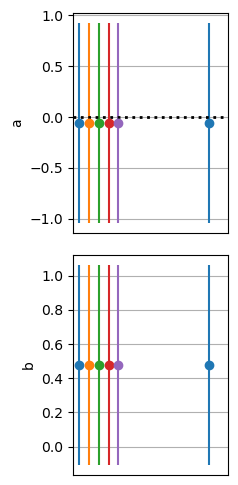

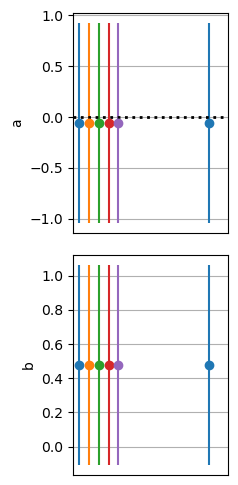

In [26]:
profiler2 = MinuitProfiler(likelihood, seed=42)
profiler2.maximize(niterations=5)
plotting.plot_aligned_stacked([profiler2.profiles, profiler.profiles], truths=True)  # truths=True will get parameter values
# Fits with the emulator and the model are the same, all good!

## Fisher
To obtain expected errors, one can run chains or perform likelihood profiling (as above). A more straightforward way is to compute the Fisher matrix.

In [27]:
from desilike import Fisher

likelihood = Likelihood()

fisher = Fisher(likelihood)
# Compute fisher around previous best fit
fisher = fisher(**profiles.bestfit.choice(varied=True))   # this accounts for priors; to ignore priors, fisher.precision
print(fisher.to_stats(tablefmt='pretty'))

[000030.53] [0/1] 02-05 12:04  Differentiation           INFO     Varied parameters: ['a', 'b'].
[000030.56] [0/1] 02-05 12:04  Differentiation           INFO     Using auto-differentiation for parameter a.
[000030.57] [0/1] 02-05 12:04  Differentiation           INFO     Using auto-differentiation for parameter b.
[000030.57] [0/1] 02-05 12:04  Differentiation           INFO     Differentiation will evaluate 1 points.
+-----+------+
| FoM | 3.21 |
+-----+------+
+------+-------+------+
|      |   a   |  b   |
+------+-------+------+
| mean | -0.06 | 0.48 |
| std  | 0.98  | 0.58 |
+------+-------+------+
+---+-------+-------+
|   |   a   |   b   |
+---+-------+-------+
| a | 0.97  | -0.48 |
| b | -0.48 | 0.34  |
+---+-------+-------+


Removed no burn in


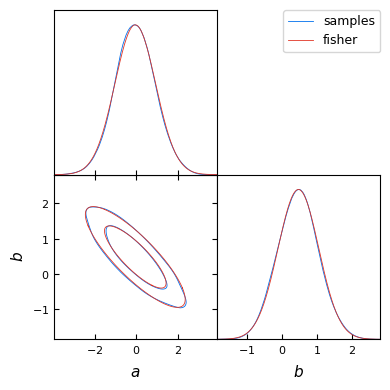

In [28]:
# Let's compare with the chains
plotting.plot_triangle([chain, fisher], labels=['samples', 'fisher'])